In [25]:
# Timestamp is the time the I/O was issued in "Windows filetime"
# Hostname is the hostname (should be the same as that in the trace file name)
# DiskNumber is the disknumber (should be the same as in the trace file name)
# Type is "Read" or "Write"
# Offset is the starting offset of the I/O in bytes from the start of the logical
# disk.
# Size is the transfer size of the I/O request in bytes.
# ResponseTime is the time taken by the I/O to complete, in Windows filetime
# units.

## Trace analysis - 7 Days

### All accesses wrt each block

In [27]:
# URL - http://iotta.snia.org/traces/388



# Graph References - MSR Paper - https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4636097


# Starting Time - 2007-02-22 19:55:39.434557
# Ending Time - 2007-03-01 17:22:03.093349




# Make 3 maps, read-only, write-only, both


import pandas as pd
import math
import collections
from datetime import datetime, timedelta


import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14,40)})


data = pd.read_csv('mds_0.csv', names=["Timestamp", "Hostname", "DiskNumber", "Type", "Offset", "Size", "ResponseTime"])
data.head()
# data.shape

,Timestamp,Hostname,DiskNumber,Type,Offset,Size,ResponseTime
0,128166372010810581,mds,0,Write,2654453760,4096,54086
1,128166372011594132,mds,0,Write,3154132992,4096,51785
2,128166372011600556,mds,0,Write,3201662976,20480,45361
3,128166372011606862,mds,0,Write,3154124800,4096,39055
4,128166372017062367,mds,0,Write,57819136,4096,52301


In [28]:
# PART 1 - All Access

block_counter_dict = {}
block_read_counter_dict = {}
block_write_counter_dict = {}



for row in data.itertuples():
        
    # taking block size = 4KB
    block_index = int(row.Offset / 4096)
    
    flag_r = False
    if (row.Type == 'Read'):
        flag_r = True  # else flag = Write  
        
    
        
    # using offset iterate over the next blocks
    next_blocks_count = int(row.Size / 4096)

    # Incrememnt next blocks counter ------- start from 1 as 0th block already added
    for i in range(0, next_blocks_count):
        if (block_index+i in block_counter_dict):
            block_counter_dict[block_index+i] += 1            
        else:
            block_counter_dict[block_index+i] = 1
            
    
    
    
    # Read and Write counters
    for i in range(0, next_blocks_count):
        if (flag_r):
            if (block_index+i in block_read_counter_dict):
                block_read_counter_dict[block_index+i] += 1
            else:
                block_read_counter_dict[block_index+i] = 1
        else:        # else means write
            if (block_index+i in block_write_counter_dict):
                block_write_counter_dict[block_index+i] += 1
            else:
                block_write_counter_dict[block_index+i] = 1
    
    
print ("Number of blocks accessed", len(block_counter_dict))
print ("Sum of all the block accesses", sum(block_counter_dict.values()))
# print (block_counter_dict)




sorted_block_counter_dict = collections.OrderedDict(sorted(block_counter_dict.items()))
sorted_block_read_counter_dict = collections.OrderedDict(sorted(block_read_counter_dict.items()))
sorted_block_write_counter_dict = collections.OrderedDict(sorted(block_write_counter_dict.items()))


# print(sorted_block_counter_dict)

# print(sorted(block_counter_dict.values(), reverse=True))

Number of blocks accessed 802284
Sum of all the block accesses 2703897


In [29]:
# df = pd.DataFrame(sorted_block_counter_dict, index=[1])
# df = pd.DataFrame.from_dict(sorted_block_counter_dict.items(), orient='index')
sorted_df = pd.DataFrame.from_dict(sorted_block_counter_dict, orient='index')

print(sorted_df)


sorted_read_df = pd.DataFrame.from_dict(sorted_block_read_counter_dict, orient='index')
sorted_write_df = pd.DataFrame.from_dict(sorted_block_write_counter_dict, orient='index')


         0
4        5
5        4
6        1
7        1
8        1
...     ..
8890904  1
8890905  1
8890906  1
8890907  1
8890908  1

[802284 rows x 1 columns]


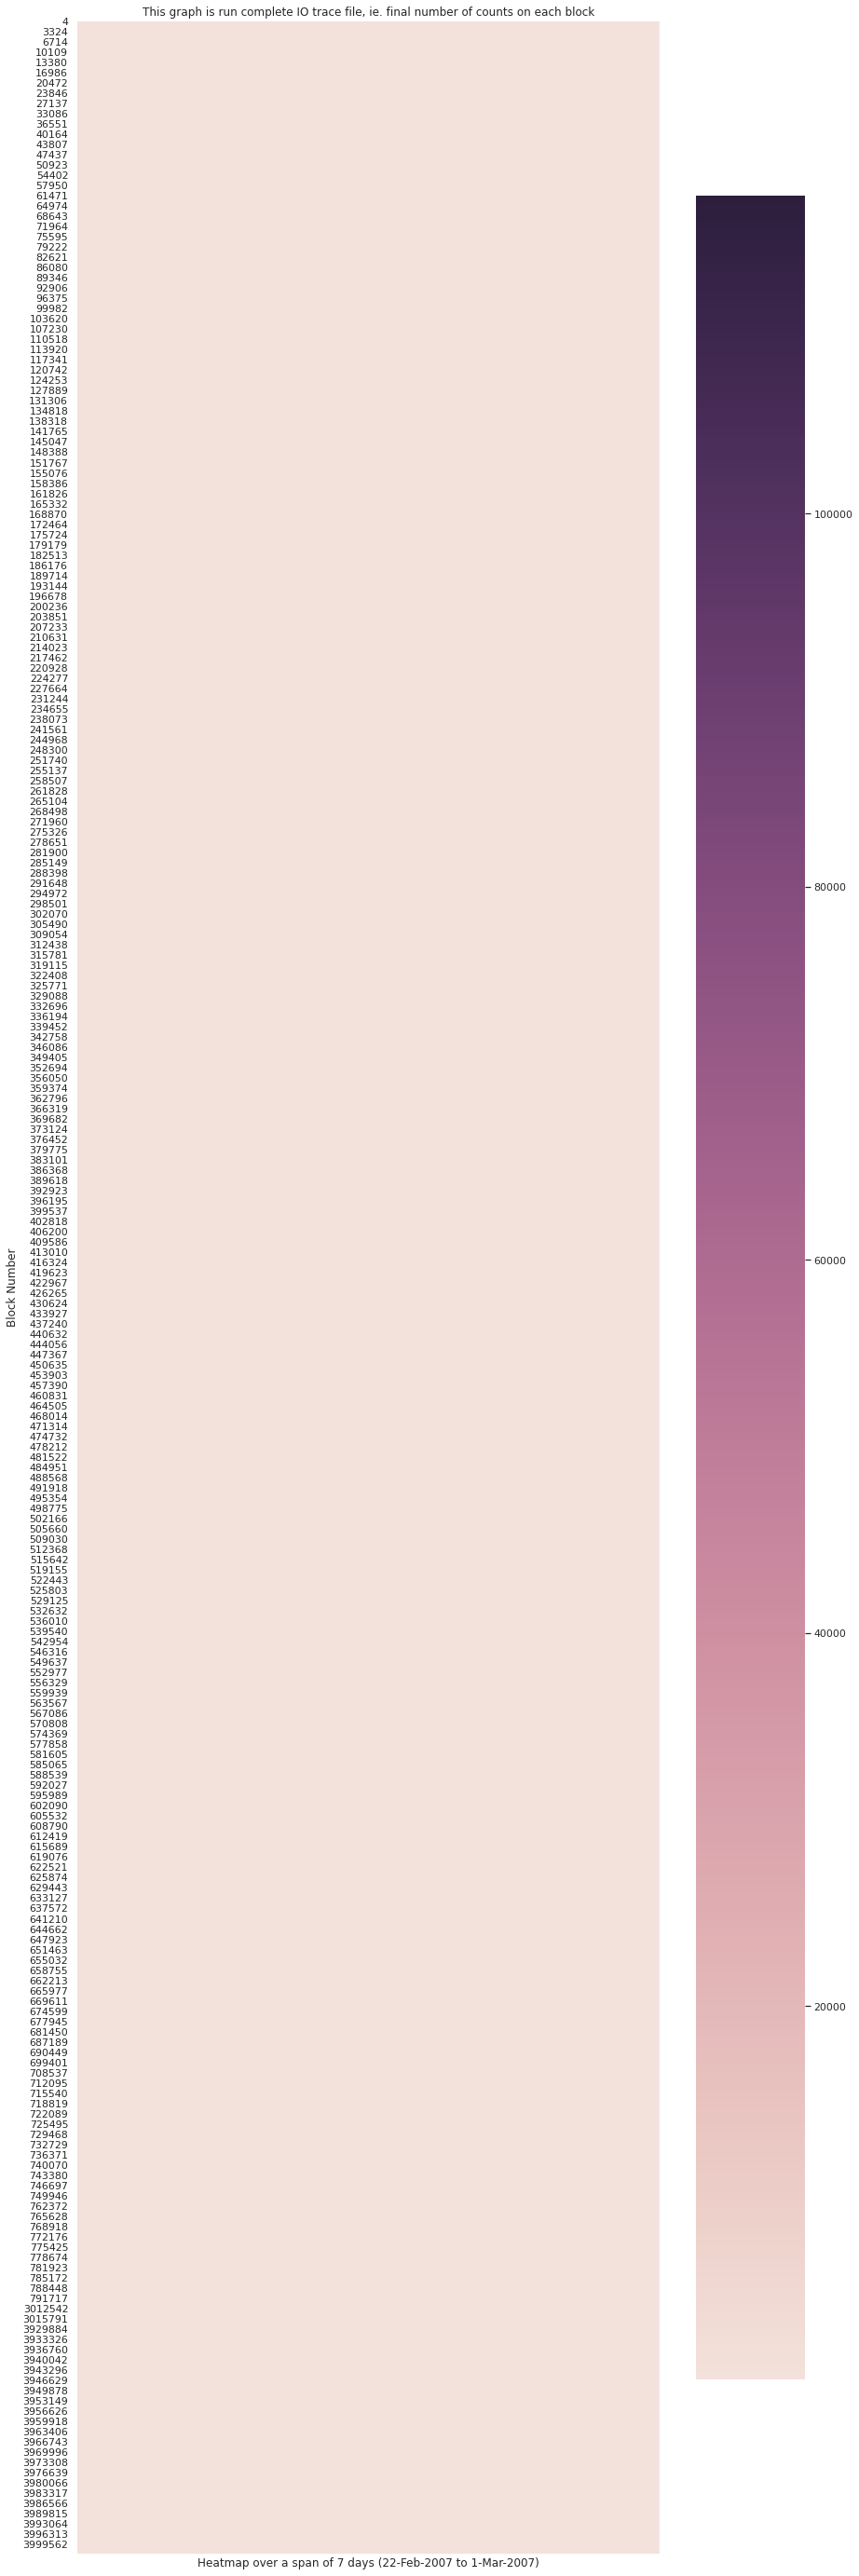

In [30]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('Heatmap over a span of 7 days (22-Feb-2007 to 1-Mar-2007)')
plt.ylabel('Block Number')
plt.title('This graph is run complete IO trace file, ie. final number of counts on each block')
plt.show()


### Plot of number of reads and writes wrt each block

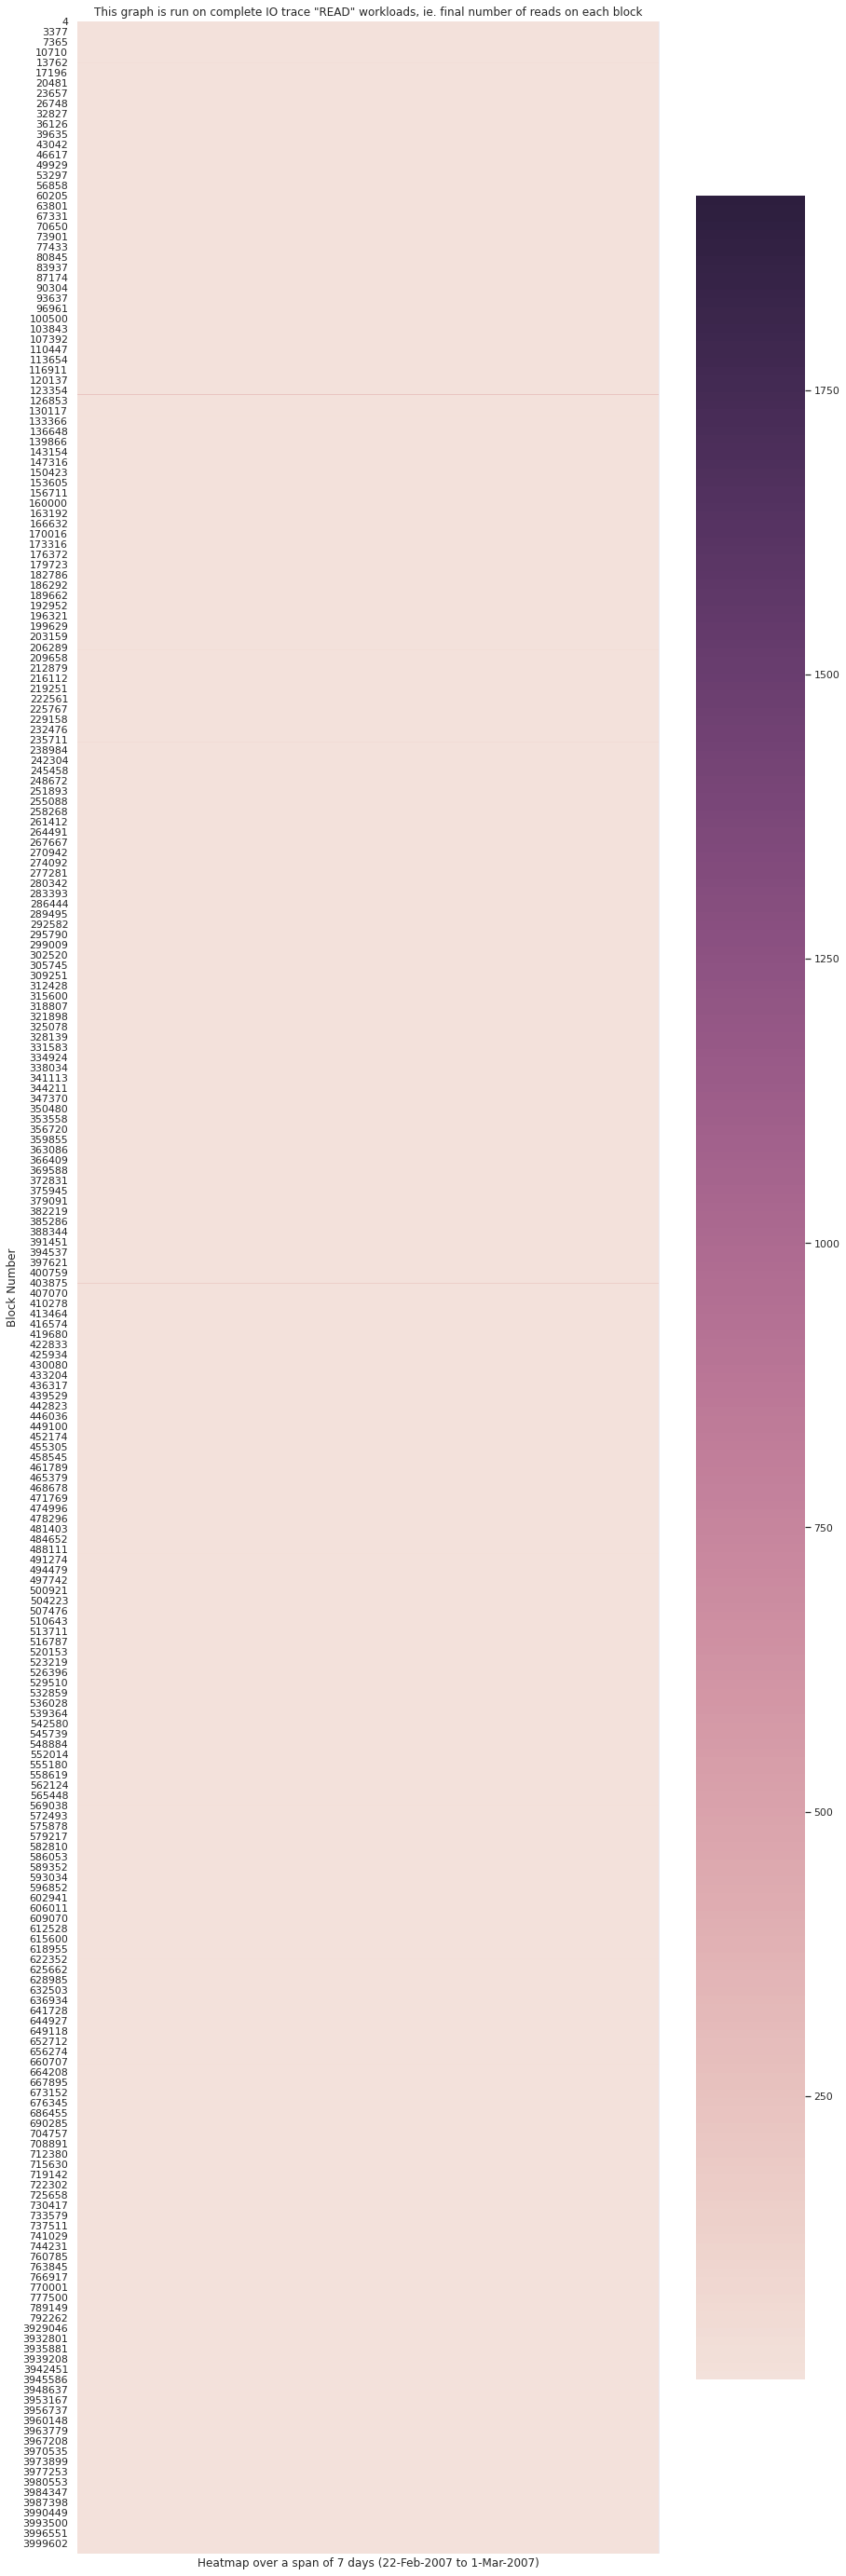

In [31]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_read_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('Heatmap over a span of 7 days (22-Feb-2007 to 1-Mar-2007)')
plt.ylabel('Block Number')
plt.title('This graph is run on complete IO trace "READ" workloads, ie. final number of reads on each block')
plt.show()


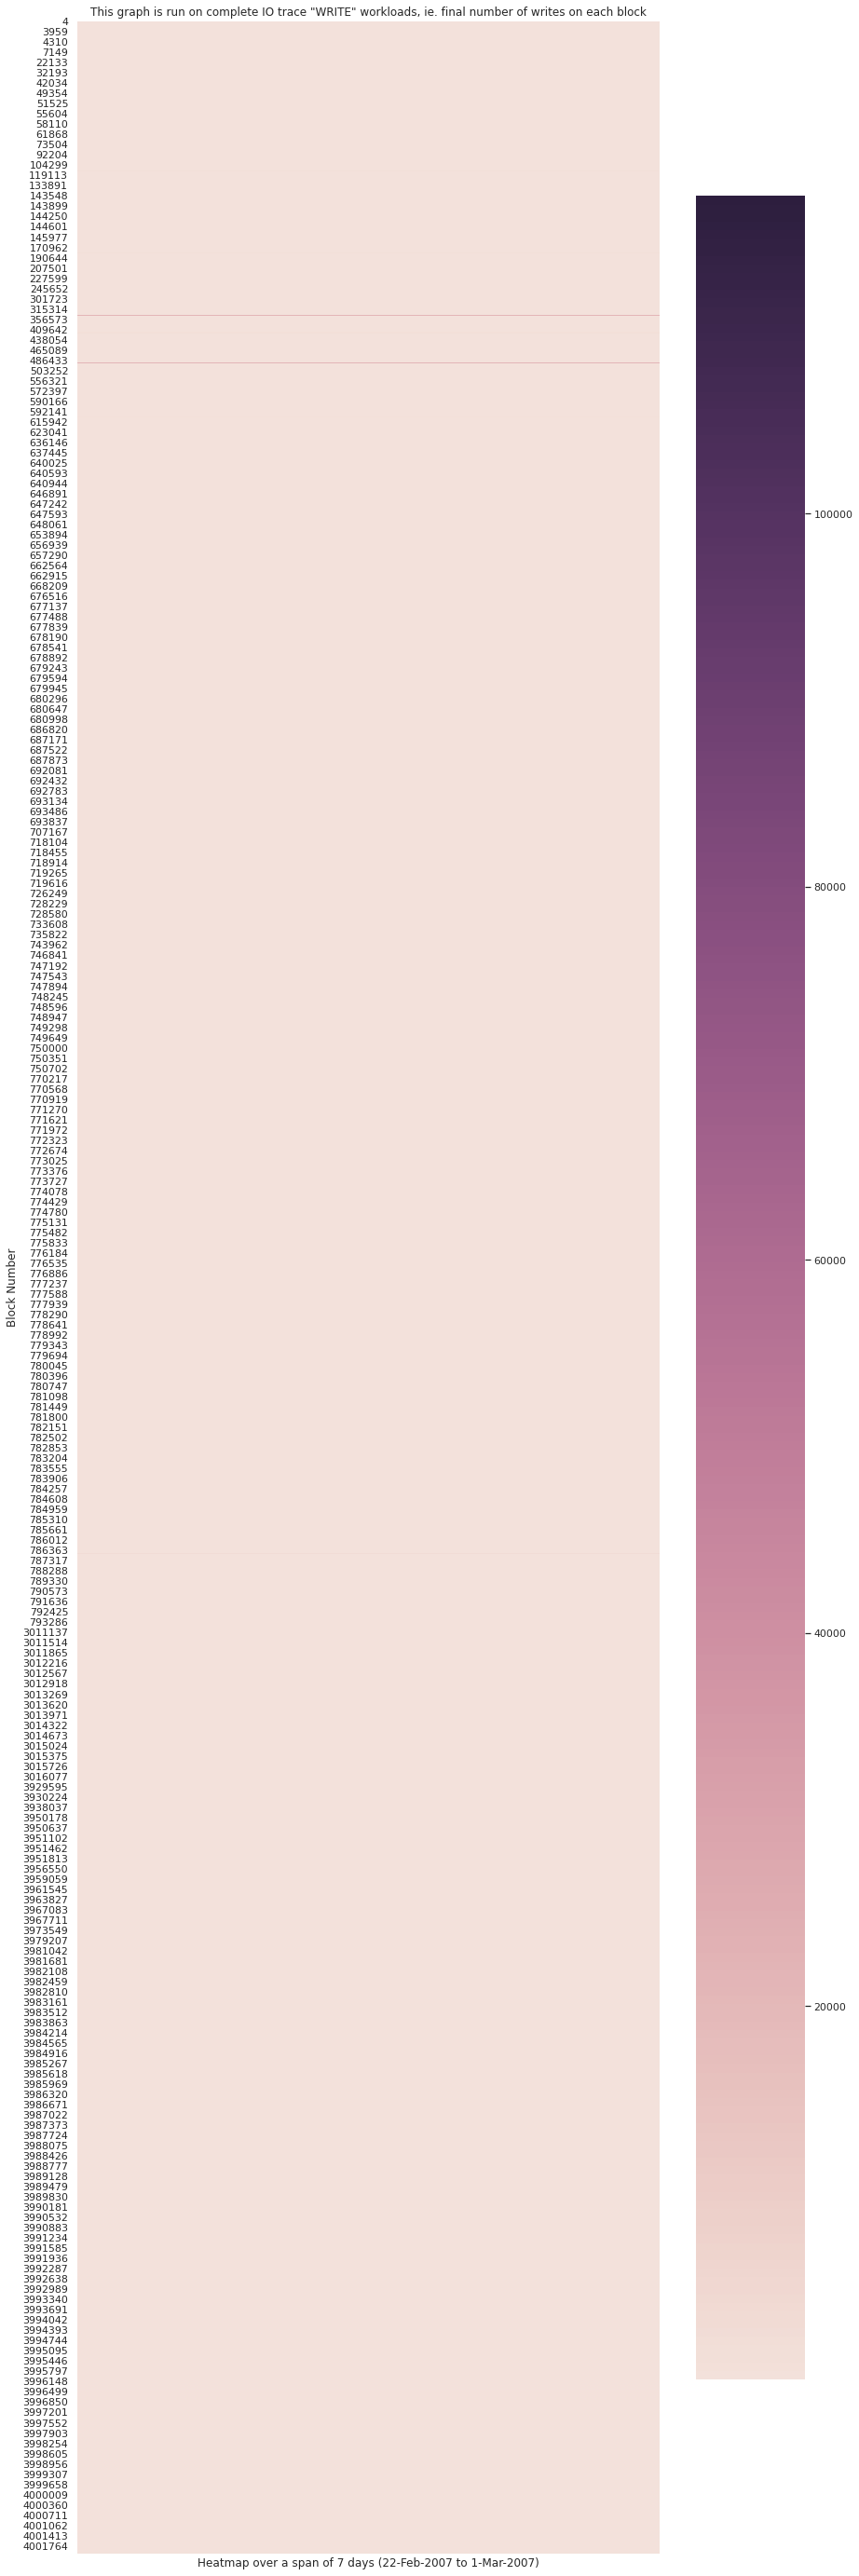

In [32]:
sns.set(rc={'figure.figsize':(14,50)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(sorted_write_df, cmap=cmap_i, xticklabels=False)
plt.xlabel('Heatmap over a span of 7 days (22-Feb-2007 to 1-Mar-2007)')
plt.ylabel('Block Number')
plt.title('This graph is run on complete IO trace "WRITE" workloads, ie. final number of writes on each block')
plt.show()


### Distribution functions

In [33]:
block_range_2000_plus = 0
block_range_1000_2000 = 0
block_range_500_1000 = 0
block_range_100_500 = 0
block_range_50_100 = 0
block_range_10_50 = 0
block_range_2_10 = 0
block_range_1 = 0
block_range_0 = 0



list_block_access_desc = sorted(block_counter_dict.values(), reverse=True)
# print (type(l), l)

for i in list_block_access_desc:
    if i >= 2000:
        block_range_2000_plus += 1
    elif i >= 1000 and i < 2000:
        block_range_1000_2000 += 1
    elif i >= 500 and i < 1000:
        block_range_500_1000 += 1
    elif i >= 100 and i < 500:
        block_range_100_500 += 1
    elif i >= 50 and i < 100:
        block_range_50_100 += 1
    elif i >=10 and i <= 50:
        block_range_10_50 += 1
    elif i >=2 and i <= 10:
        block_range_2_10 += 1
    elif i == 1:
        block_range_1 += 1
        
total_number_of_blocks = max(block_counter_dict)
block_range_0 = (total_number_of_blocks - (len(block_counter_dict)))


# print("block_range_2000_plus", block_range_2000_plus)
# print("block_range_1000_2000", block_range_1000_2000)
# print("block_range_500_1000", block_range_500_1000)
# print("block_range_100_500", block_range_100_500)
# print("block_range_50_100", block_range_50_100)
# print("block_range_10_50", block_range_10_50)
# print("block_range_2_10", block_range_2_10)
# print("block_range_1", block_range_1)
# print("block_range_0", block_range_0)


In [34]:
# len(block_counter_dict) 90.976

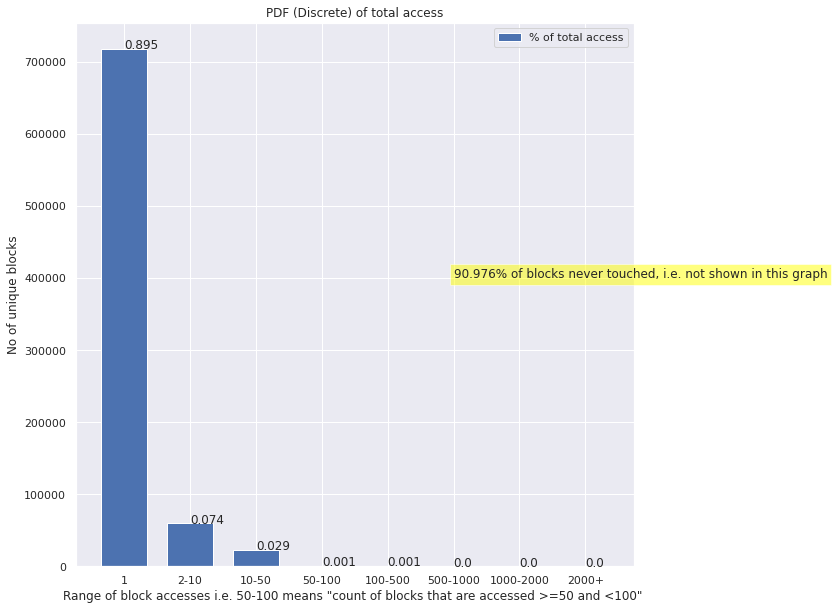

In [35]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(10,10))


x_axis = ["1", "2-10", "10-50", "50-100", "100-500", "500-1000", "1000-2000", "2000+"]

y_axis = [block_range_1, block_range_2_10, block_range_10_50,
          block_range_50_100, block_range_100_500, block_range_500_1000,
          block_range_1000_2000, block_range_2000_plus]

pyplot.bar(x_axis, y_axis, width=0.7, label='% of total access')
# pyplot.bar(x_h, host_read_latency, width=0.7, label='Oasis')
# pyplot.xticks([])
pyplot.legend(loc='upper right')
pyplot.title("PDF (Discrete) of total access")
pyplot.ylabel('No of unique blocks')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
pyplot.text(5, 400000, "90.976% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))

for i in range(len(x_axis)):
    pyplot.annotate(str(round(y_axis[i]/len(block_counter_dict), 3)), xy=(x_axis[i], y_axis[i]))



In [36]:
def ecdf(data):
    """ Compute ECDF """
#     x = np.sort(data)
    n = len(data)
#     y = np.arange(1, data) / n

    cumsum = 0
    y = []
    for i in range(len(data)):
        cumsum += data[i]
        y.append(round(cumsum/len(block_counter_dict), 3))

    return y

Text(4, 0.96, '90.976% of blocks never touched, i.e. not shown in this graph')

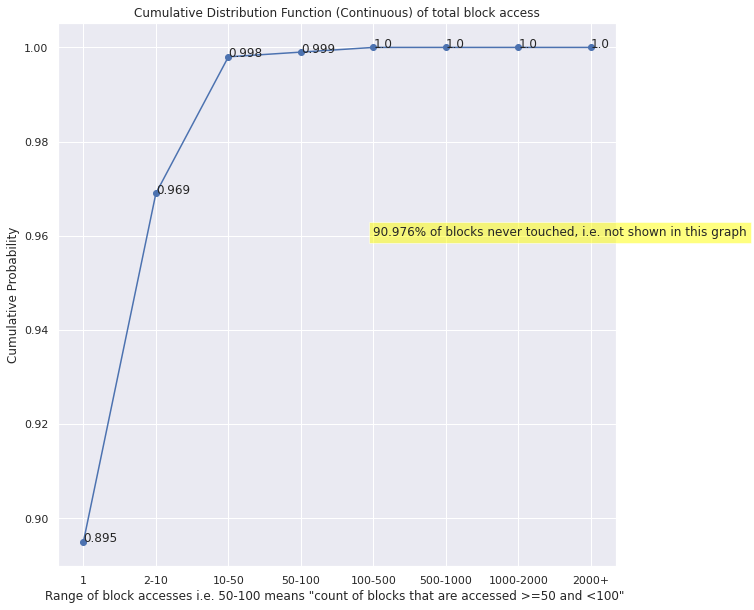

In [37]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import numpy as np

y = ecdf(y_axis)



########## PLOTLY CODE not visible on github

# trace = go.Scatter(x=x_axis,
#                    y=y,
#                    marker=dict(color='rgb(150, 25, 120)'))


# layout = go.Layout(
#     title="Cumulative Distribution Function"
# )

# fig = go.Figure(data=go.Data([trace]), layout=layout)

# fig.update_layout(
# #     title="Plot Title",
#     xaxis_title="Range of block access",
#     yaxis_title="CDF (continuous)"
# #     font=dict(
# #         family="Courier New, monospace",
# #         size=18,
# #         color="#7f7f7f"
# #     )
# )
# fig.show()


pyplot.figure(figsize=(10,10))
pyplot.scatter(x=x_axis, y=y)
pyplot.plot(x_axis, y)
for i in range(len(x_axis)):
    pyplot.annotate(str(y[i]), xy=(x_axis[i], y[i]))
# pyplot.legend(loc='upper right')
pyplot.title("Cumulative Distribution Function (Continuous) of total block access")
pyplot.ylabel('Cumulative Probability')
pyplot.xlabel('Range of block accesses i.e. 50-100 means "count of blocks that are accessed >=50 and <100" ')
pyplot.text(4, 0.96, "90.976% of blocks never touched, i.e. not shown in this graph", bbox=dict(facecolor='yellow', alpha=0.5))


## Trace Analysis - time series plot

### All accesses wrt each block

In [23]:
def convert_filetime_to_datetime(ft):
    return datetime.utcfromtimestamp((ft - 116444736000000000) / 10000000)


In [24]:
# Part 2 - This is time series data



# Reset all the values to zero
# new_block_dict = dict.fromkeys(sorted_block_counter_dict, 0)

set_pivot_timer = convert_filetime_to_datetime(data.Timestamp[0])
set_hours = 1
result_df = pd.DataFrame()
result_read_df = pd.DataFrame()
result_write_df = pd.DataFrame()

granularity_y_axis = 1000
granularity_x_axis = 20

time_series_dict = dict.fromkeys(range(granularity_y_axis+1), 0)
time_series_read_dict = dict.fromkeys(range(granularity_y_axis+1), 0)
time_series_write_dict = dict.fromkeys(range(granularity_y_axis+1), 0)

flag = False
dataframe_column_count = 0

# Now keep granularity_y_axis, i.e. block_ranges on y-axis for better visualisation
block_range_size = sorted_df.index[-1] // granularity_y_axis


for row in data.itertuples():
    
    # print (type(convert_filetime_to_datetime(row.Timestamp)), convert_filetime_to_datetime(row.Timestamp))
    

    
    # Time visualisation can be seen in above print statement - Collect trace map for every X-hrs
    current_io_time = convert_filetime_to_datetime(row.Timestamp)
    if abs(current_io_time - set_pivot_timer) > timedelta(hours=set_hours):
        # 6 hours limit crossed, set a flag and record new entries
        flag = True
        df = pd.DataFrame.from_dict(time_series_dict, orient='index')
        result_df[dataframe_column_count] = df[0].values
        
        df = pd.DataFrame.from_dict(time_series_read_dict, orient='index')
        result_read_df[dataframe_column_count] = df[0].values
        
        df = pd.DataFrame.from_dict(time_series_write_dict, orient='index')
        result_write_df[dataframe_column_count] = df[0].values
        
        # update pivot timer to current one
        set_pivot_timer = current_io_time
        print ("set_pivot_timer", set_pivot_timer)
        
        dataframe_column_count += 1
        
        
        
        
        
    # Reintialize dict if just copied to dataframe    
    if flag == True:
        time_series_dict = dict.fromkeys(range(granularity_y_axis + 1), 0)
        time_series_read_dict = dict.fromkeys(range(granularity_y_axis + 1), 0)
        time_series_write_dict = dict.fromkeys(range(granularity_y_axis + 1), 0)
        flag = False
    
    
    
    
    # taking block size = 4KB    
    block_index = row.Offset // 4096
    # using offset iterate over the next blocks
    next_blocks_count = row.Size // 4096

    
    
    
    # Increment next blocks counter -------
    for i in range(0, next_blocks_count):
        time_series_dict[(block_index+i) // block_range_size] += 1
        if (row.Type == "Read"):
            time_series_read_dict[(block_index+i) // block_range_size] += 1
        else:
            time_series_write_dict[(block_index+i) // block_range_size] += 1
        
        
        
        
#     flag = False
    # No of time periods defined here
    if dataframe_column_count > granularity_x_axis:
        break

        
        
# loop ended, copy last time period data
if flag == False and dataframe_column_count <= granularity_x_axis:
    df = pd.DataFrame.from_dict(time_series_dict, orient='index')
    result_df[dataframe_column_count] = df[0].values
        
print (result_df)

set_pivot_timer 2007-02-22 18:00:19.886064
set_pivot_timer 2007-02-22 19:00:26.788830
set_pivot_timer 2007-02-22 20:00:28.605808
set_pivot_timer 2007-02-22 21:00:29.155291
set_pivot_timer 2007-02-22 22:00:29.244414
set_pivot_timer 2007-02-22 23:00:29.535516
set_pivot_timer 2007-02-23 00:00:31.267418
set_pivot_timer 2007-02-23 01:00:38.162635
set_pivot_timer 2007-02-23 02:00:45.002924
set_pivot_timer 2007-02-23 03:00:45.021375
set_pivot_timer 2007-02-23 04:00:45.023575
set_pivot_timer 2007-02-23 05:00:45.458852
set_pivot_timer 2007-02-23 06:00:46.630899
set_pivot_timer 2007-02-23 07:00:46.679249
set_pivot_timer 2007-02-23 08:00:47.010053
set_pivot_timer 2007-02-23 09:00:47.010079
set_pivot_timer 2007-02-23 10:00:47.010350
set_pivot_timer 2007-02-23 11:00:47.022124
set_pivot_timer 2007-02-23 12:00:47.023401
set_pivot_timer 2007-02-23 13:00:47.024135
set_pivot_timer 2007-02-23 14:00:47.026594
        0     1     2     3     4     5     6     7     8     9   ...    11  \
0      675   538  

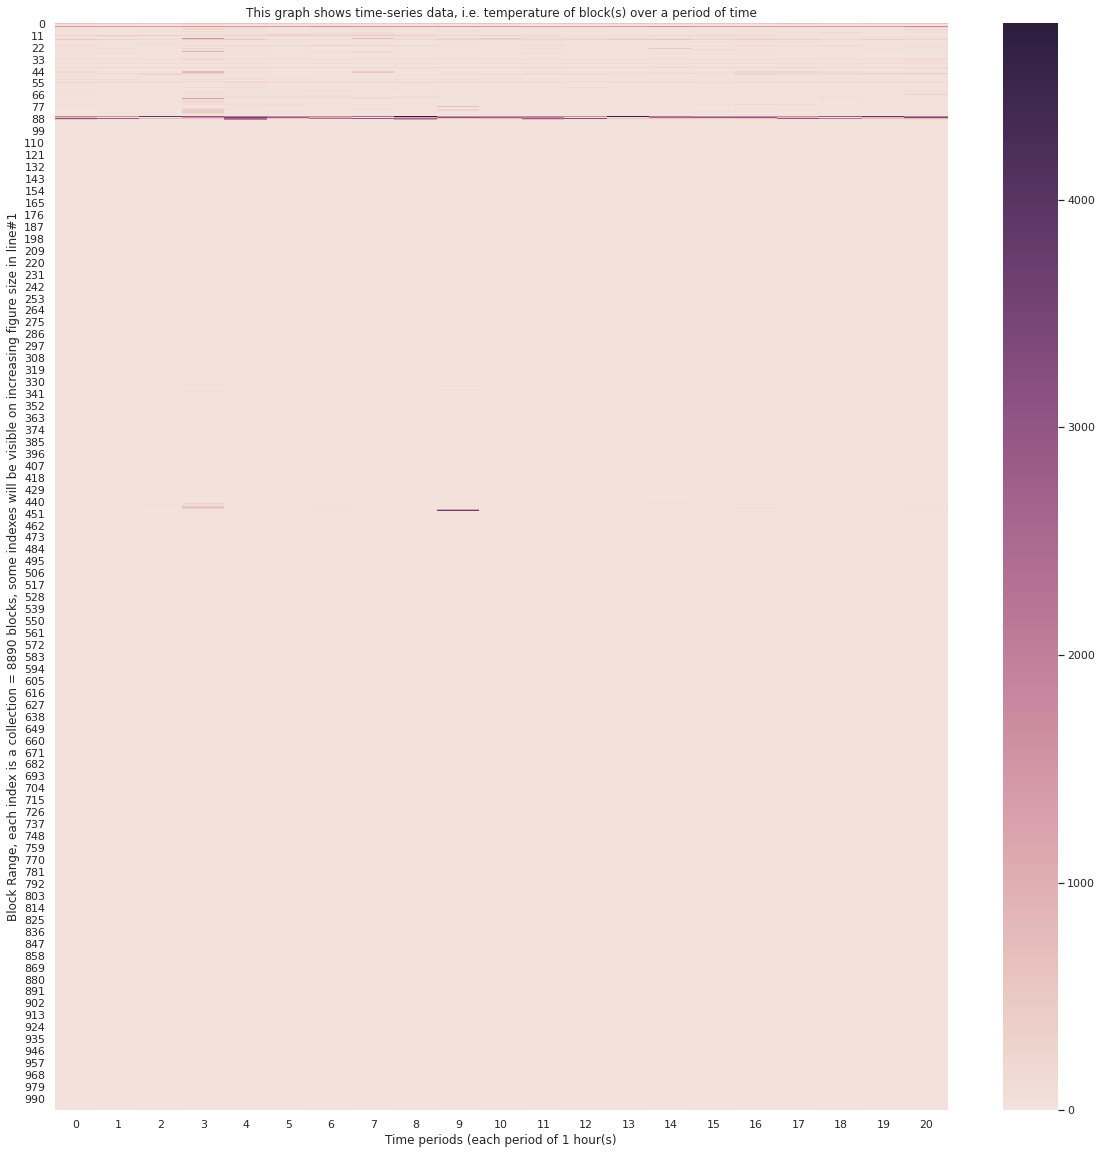

In [25]:
sns.set(rc={'figure.figsize':(20,20)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(result_df, cmap=cmap_i)
plt.xlabel('Time periods (each period of %s hour(s)' % set_hours)
plt.ylabel('Block Range, each index is a collection = %d blocks, some indexes will be visible on increasing figure size in line#1' % block_range_size)

plt.title('This graph shows time-series data, i.e. temperature of block(s) over a period of time')
plt.show()


### Plot of number of reads and writes wrt each block

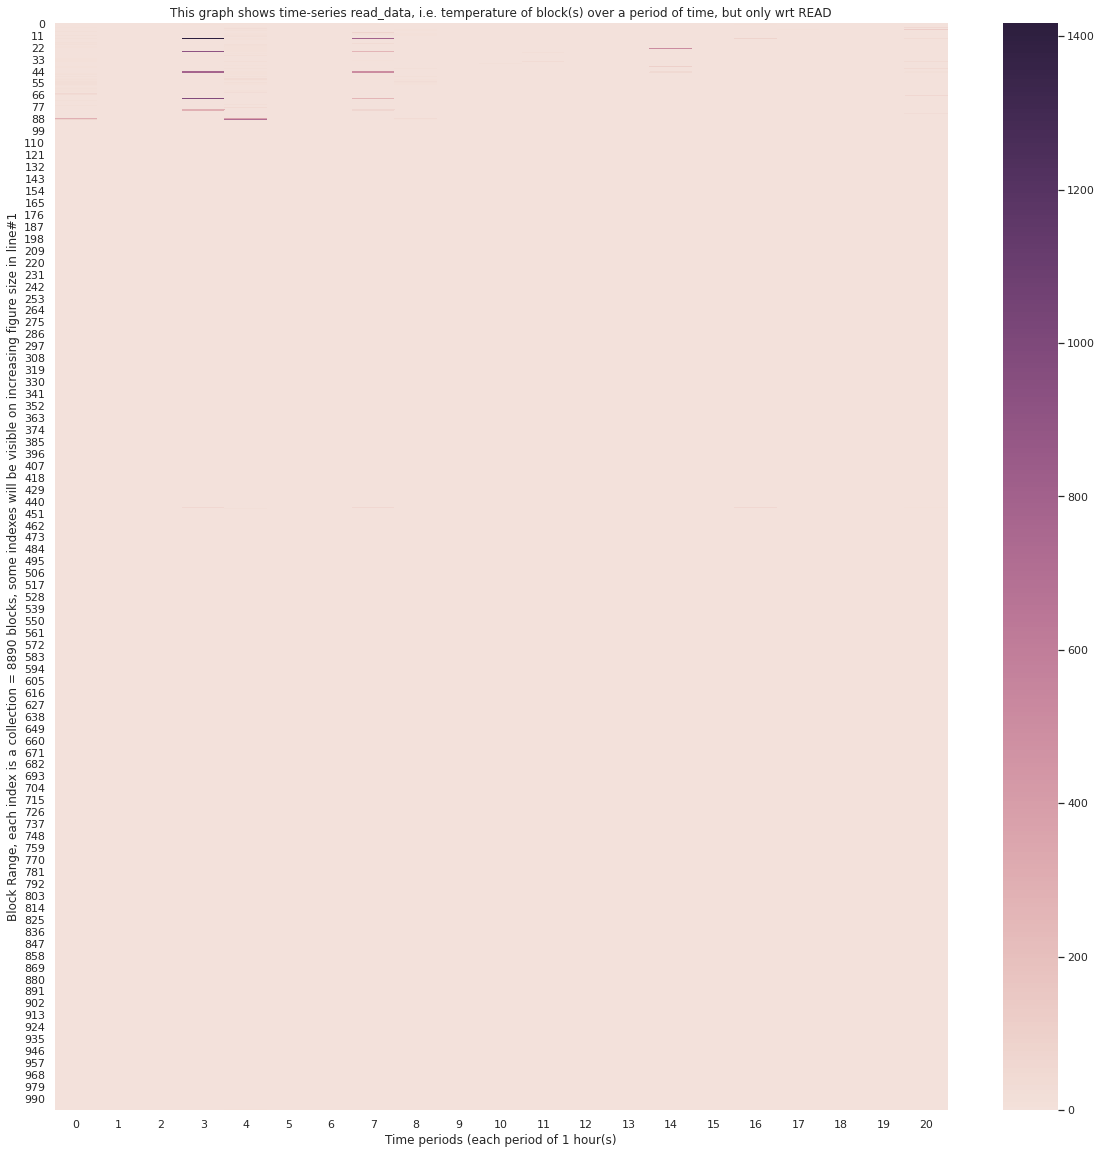

In [28]:
sns.set(rc={'figure.figsize':(20,20)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(result_read_df, cmap=cmap_i)
plt.xlabel('Time periods (each period of %s hour(s)' % set_hours)
plt.ylabel('Block Range, each index is a collection = %d blocks, some indexes will be visible on increasing figure size in line#1' % block_range_size)

plt.title('This graph shows time-series read_data, i.e. temperature of block(s) over a period of time, but only wrt READ')
plt.show()


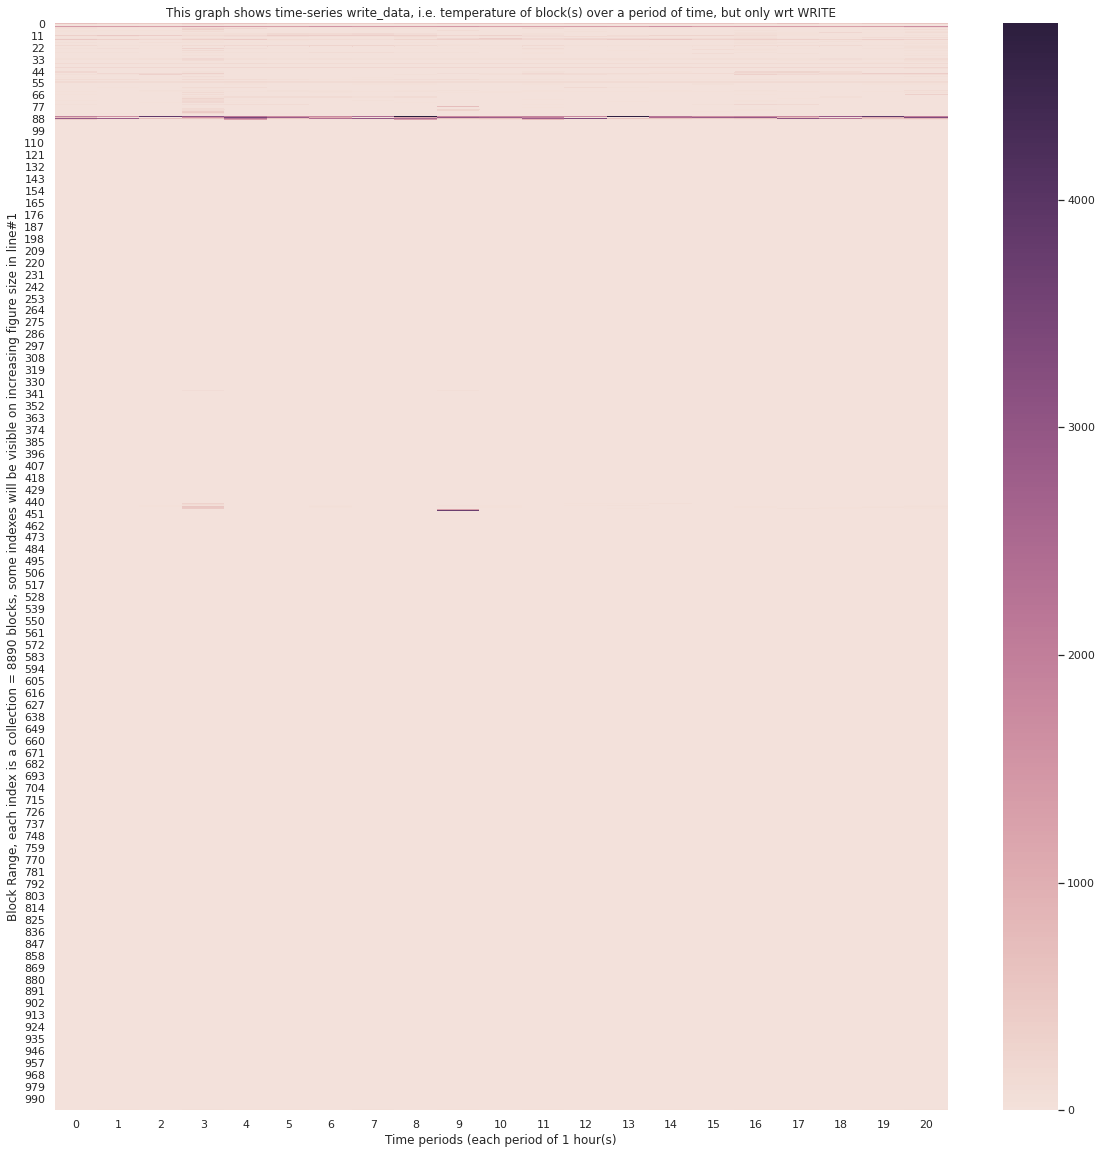

In [27]:
sns.set(rc={'figure.figsize':(20,20)})
cmap_i = sns.cubehelix_palette(as_cmap=True, light=.9)

heatmap = sns.heatmap(result_write_df, cmap=cmap_i)
plt.xlabel('Time periods (each period of %s hour(s)' % set_hours)
plt.ylabel('Block Range, each index is a collection = %d blocks, some indexes will be visible on increasing figure size in line#1' % block_range_size)

plt.title('This graph shows time-series write_data, i.e. temperature of block(s) over a period of time, but only wrt WRITE')
plt.show()


## Extras

In [9]:
print("Start time - ", convert_filetime_to_datetime(data.Timestamp[0]))
print("End time - ", convert_filetime_to_datetime(data.Timestamp[1211033]))
print(len(block_counter_dict) // 100)


Start time -  2007-02-22 17:00:01.081058
End time -  2007-03-01 17:00:04.491125
8022


In [10]:
sorted_df.index[-1]

8890908